In [1]:
!pip install -q easysnowdata # new comment

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import easysnowdata
import folium
import earthaccess
import xarray as xr
import numpy as np

In [3]:
import dask.distributed
client = dask.distributed.Client()
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37877 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/egagli/proxy/37877/status,
Dashboard: /user/egagli/proxy/37877/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37613,Workers: 4
Dashboard: /user/egagli/proxy/37877/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:38999,Total threads: 1
Dashboard: /user/egagli/proxy/43841/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:40413,


In [4]:
bbox_gdf = gpd.read_file('grand_mesa.geojson')
sample_area_gdf = gpd.read_file('../../data/sample_area.geojson')
sample_area_proj_gdf = sample_area_gdf.to_crs('EPSG:32613')

In [5]:
bbox_gdf.explore()

In [6]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=bbox_gdf, start_date="2019-10-01", end_date="2020-09-30", resolution=80, remove_border_noise=False,
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 13N.
Metadata retrieved. Access with the .metadata attribute.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [7]:
s1_rtc_sample_ds = s1.data.rio.clip(sample_area_proj_gdf.geometry)

In [8]:
# summer_slice = slice('2020-07-01','2020-08-31')
# summer_median_db = s1_rtc_ds.sel(time=summer_slice).groupby('sat:relative_orbit').median(dim=['time'])

In [9]:
# wet_snow_ds = s1_rtc_ds.groupby('sat:relative_orbit') - summer_median_db

In [10]:
# wet_snow_da = wet_snow_ds.to_dataarray('polarization')
# wet_snow_da

In [11]:
s1_rtc_sample_median_ds = s1_rtc_sample_ds.median(dim=['x','y']).compute()

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib

In [12]:
s1_rtc_sample_median_ds

<xarray.Dataset> Size: 3kB
Dimensions:             (time: 114)
Coordinates:
  * time                (time) datetime64[ns] 912B 2019-10-01T01:09:53.272349...
    sat:orbit_state     (time) object 912B 'ascending' ... 'ascending'
    sat:relative_orbit  (time) int16 228B 49 56 151 129 49 ... 49 56 151 129 49
    spatial_ref         int64 8B 0
Data variables:
    vh                  (time) float32 456B -19.51 nan nan ... nan -19.68 -19.48
    vv                  (time) float32 456B -13.05 nan nan ... nan -13.68 -12.83

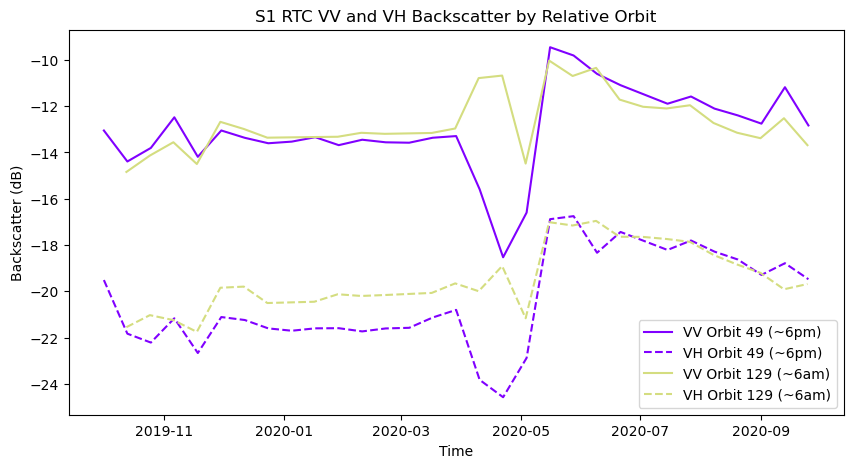

In [19]:
orbits = s1_rtc_sample_median_ds['sat:relative_orbit'].values
unique_orbits = np.unique(orbits)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_orbits)))

f,ax=plt.subplots(figsize=(10,5))

for i, orbit in enumerate(unique_orbits):

    if orbit in [56,151]:
        continue
        
    orbit_data = s1_rtc_sample_median_ds.where(s1_rtc_sample_median_ds['sat:relative_orbit'] == orbit, drop=True)

    time_of_day = "~6pm" if orbit_data['sat:orbit_state'].values[0] == "ascending" else "~6am"
    
    # Plot VV
    ax.plot(orbit_data.time, orbit_data.vv, 
             color=colors[i], linestyle='-', label=f'VV Orbit {orbit} ({time_of_day})')
    
    # Plot VH
    ax.plot(orbit_data.time, orbit_data.vh, 
             color=colors[i], linestyle='--', label=f'VH Orbit {orbit} ({time_of_day})')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Backscatter (dB)')
ax.set_title('S1 RTC VV and VH Backscatter by Relative Orbit')
ax.legend()